In [1]:
from scipy import stats
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
L21 = 0.1
L31 = -0.6
L41 = -0.7
L51 = 0
L61 = 0.4
L71 = 0.2
L32 = 0
L42 = -0.1
L52 = 0.4
L62 = 0.1
L72 = 0.1
L43 = 0.2
L53 = -0.4
L63 = 0.6
L73 = 0.01
L54 = 0.4
L64 = 0.1
L74 = -0.3
L65 = 0.3
L75 = 0.5
L76 = 0.2

In [4]:
L11 = 1

if 1-L21**2 >=0:
    L22 = np.sqrt(1-L21**2)
else:
    raise ValueError('1-L21**2 must be >=0')

if 1-L31**2-L32**2 >=0:
    L33 = np.sqrt(1-L31**2-L32**2)
else:
    raise ValueError('1-L31**2-L32**2 must be >=0')

if 1-L41**2-L42**2-L43**2 >=0:
    L44 = np.sqrt(1-L41**2-L42**2-L43**2)
else:
    raise ValueError('1-L41**2-L42**2-L43**2 must be >=0')

if 1-L51**2-L52**2-L53**2-L54**2 >=0:
    L55 = np.sqrt(1-L51**2-L52**2-L53**2-L54**2)
else:
    raise ValueError('1-L51**2-L52**2-L53**2-L54**2 must be >=0')

if 1-L61**2-L62**2-L63**2-L64**2-L65**2 >=0:
    L66 = np.sqrt(1-L61**2-L62**2-L63**2-L64**2-L65**2)
else:
    raise ValueError('1-L61**2-L62**2-L63**2-L64**2-L65**2 must be >=0')

if 1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2 >=0:
    L77 = np.sqrt(1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2)
else:
    raise ValueError('1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2 must be >=0')

In [5]:
L = [[L11, 0, 0, 0, 0, 0, 0],
     [L21, L22, 0, 0, 0, 0, 0],
     [L31, L32, L33, 0, 0, 0, 0],
     [L41, L42, L43, L44, 0, 0, 0],
     [L51, L52, L53, L54, L55, 0, 0],
     [L61, L62, L63, L64, L65, L66, 0],
     [L71, L72, L73, L74, L75, L76, L77]]

In [6]:
covmat_Z = np.dot(L, np.transpose(L))
print(covmat_Z.shape)

# The covariance (=correlation here) matrix must be non-singular and positive semi-definite: verification
if not np.all(np.linalg.eigvals(covmat_Z) >= 0):
    raise ValueError('The covariance matrix is not positive semi-definite')
if round(np.linalg.det(covmat_Z), 6) == 0:
    raise ValueError('The covariance matrix is singular')
# All entries must be in [-1,1]
if not np.all(np.abs(covmat_Z <= 1)):
    raise ValueError('All entries of the correlation matrix must be in [-1,1]')

(7, 7)


In [7]:
mvnorm = stats.multivariate_normal(mean=np.zeros(covmat_Z.shape[0]), cov=covmat_Z)

m1 = stats.norm(2,0.6)
m2 = stats.norm(0.2,0.3)
m3 = stats.norm(-0.3,2)
m4 = stats.norm(0.7,0.4)
m5 = stats.uniform()
m6 = stats.uniform()
m7 = stats.uniform()

p_a = 0.3
tau_a = 1 - p_a

p_b = 0.9
tau_b = 1-p_b

p_y = 0.2
tau_y = 1 - p_y

In [8]:
!mkdir bias_data

datasets=[]
for i in tqdm(range(100)):
    z = mvnorm.rvs(100000)
    u = stats.norm.cdf(z)
    x1 = m1.ppf(u[:, 0])
    x2 = m2.ppf(u[:, 1])
    x3 = m3.ppf(u[:, 2])
    x4 = m4.ppf(u[:, 3])
    x5 = m5.ppf(u[:, 4])
    x6 = m6.ppf(u[:, 5])
    x7 = m7.ppf(u[:, 6])
    a = np.zeros(len(x5), dtype=int)
    a[x5 >= tau_a] = 1
    b = np.zeros(len(x6), dtype=int)
    b[x6 >= tau_b] = 1
    y = np.zeros(len(x7), dtype=int)
    y[x7 >= tau_y] = 1
    data = pd.DataFrame({'X1':x1, 'X2':x2, 'X3':x3, 'X4':x4, 'A':a, 'B':b, 'Y':y})
#     data.to_csv('bias_data/synthetic_data_v2010_' + str(i) + '.csv', index=False)
    datasets.append(data)

mkdir: cannot create directory ‘bias_data’: File exists


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


In [9]:
datasets[0]

,X1,X2,X3,X4,A,B,Y
0,2.418701,0.514158,-0.773733,0.248622,0,1,1
1,2.656955,0.607767,-1.018263,0.042741,0,1,0
2,2.281514,0.136697,0.642054,0.049141,0,1,0
3,1.532804,0.572560,2.638396,1.075462,0,1,0
4,1.534743,0.473876,1.119784,1.099088,0,1,0
...,...,...,...,...,...,...,...
99995,1.736249,0.201086,1.411251,0.558373,0,1,1
99996,1.947005,0.304566,0.179316,0.878829,0,0,0
99997,1.923147,0.128804,0.689729,0.805265,0,1,0
99998,2.484839,0.890783,0.585000,0.491699,0,1,0


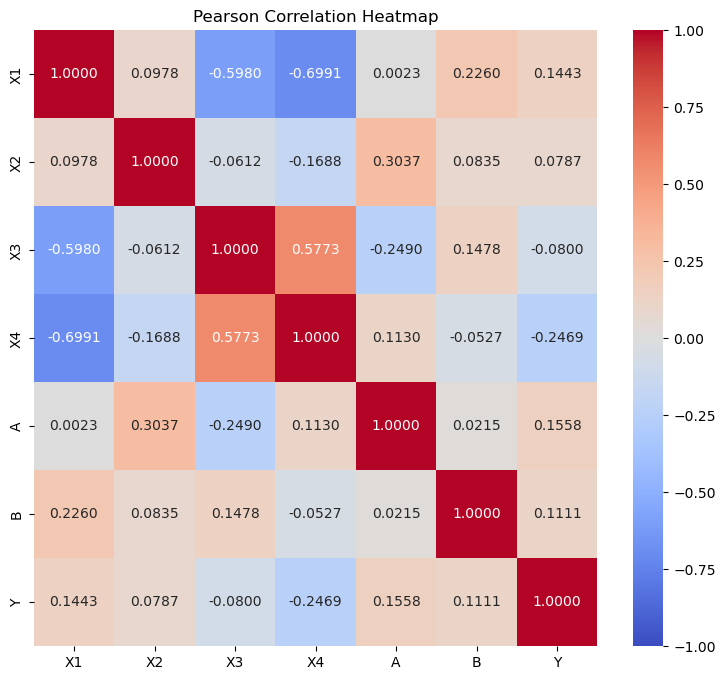

In [10]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim-2)
        self.relu = nn.ReLU()
    def forward(self, x):
#         return self.relu(self.fc1(x))
        return self.fc1(x)

In [12]:
class Predictor(nn.Module):
    def __init__(self, input_dim):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.fc1(x))

In [13]:
class Adversary(nn.Module):
    def __init__(self, input_dim):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.fc1(x))

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe[['X1', 'X2', 'X3', 'X4', 'A', 'B']].values, dtype=torch.float32)
#         self.A = torch.tensor(dataframe[['A']].values, dtype=torch.float32)
#         self.B = torch.tensor(dataframe[['B']].values, dtype=torch.float32)
        self.Y = torch.tensor(dataframe[['Y']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
#         return self.X[idx], self.A[idx], self.B[idx], self.Y[idx]
        return self.X[idx], self.Y[idx]

dataset = CustomDataset(datasets[0])
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [15]:
encoder = Encoder(6)
predictor = Predictor(4)
adversaryA = Adversary(4)
adversaryB = Adversary(4)

In [16]:
learning_rate = 0.01

criterion_enc = nn.MSELoss()
criterion_pred = nn.BCELoss()
criterion_advA = nn.BCELoss()
criterion_advB = nn.BCELoss()

optimizer_pred = optim.Adam(predictor.parameters(), lr=learning_rate)
optimizer_advA = optim.Adam(adversaryA.parameters(), lr=learning_rate)
optimizer_advB = optim.Adam(adversaryB.parameters(), lr=learning_rate)
optimizer_enc = optim.Adam(encoder.parameters(), lr=learning_rate)

In [17]:
for a,b in dataloader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([256, 6])
torch.Size([256, 1])


In [18]:
num_epochs = 5
encoder.train()

gradient_norms_enc = []
epochs_enc = []

In [19]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        encoder.zero_grad()
        x_recon = encoder(data)
        lx = criterion_enc(x_recon, data[:,:4])
        lx.backward()

        batch_gradient_norm = 0.0
        for p in encoder.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_enc.step()
    
    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_enc.append(average_gradient_norm)
    epochs_enc.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Recon: {lx.item():.4f}')

Epoch [1/5], Loss Recon: 0.0210
Epoch [2/5], Loss Recon: 0.0054
Epoch [3/5], Loss Recon: 0.0015
Epoch [4/5], Loss Recon: 0.0004
Epoch [5/5], Loss Recon: 0.0001


In [20]:
gradient_norms_enc

[0.5979285091197596,
 0.042204702864866085,
 0.018036485115157347,
 0.00821181799774288,
 0.004224529188066399]

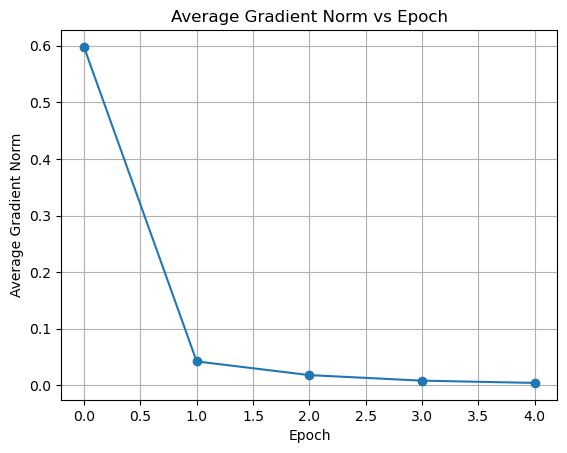

In [21]:
plt.plot(epochs_enc, gradient_norms_enc, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [27]:
# index = 0
# df_original = datasets[index].copy()

# dataset = CustomDataset(df_original)
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# encoder_outputs = []
# encoder.eval()
# with torch.no_grad():
#     for batch_X, _ in dataloader:
#         output = encoder(batch_X)
#         encoder_outputs.append(output)
# encoder_outputs = torch.cat(encoder_outputs, dim=0)

# encoder_outputs_np = encoder_outputs.numpy()
# df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

# df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B], axis=1)

# correlation_matrix = df.corr()

# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

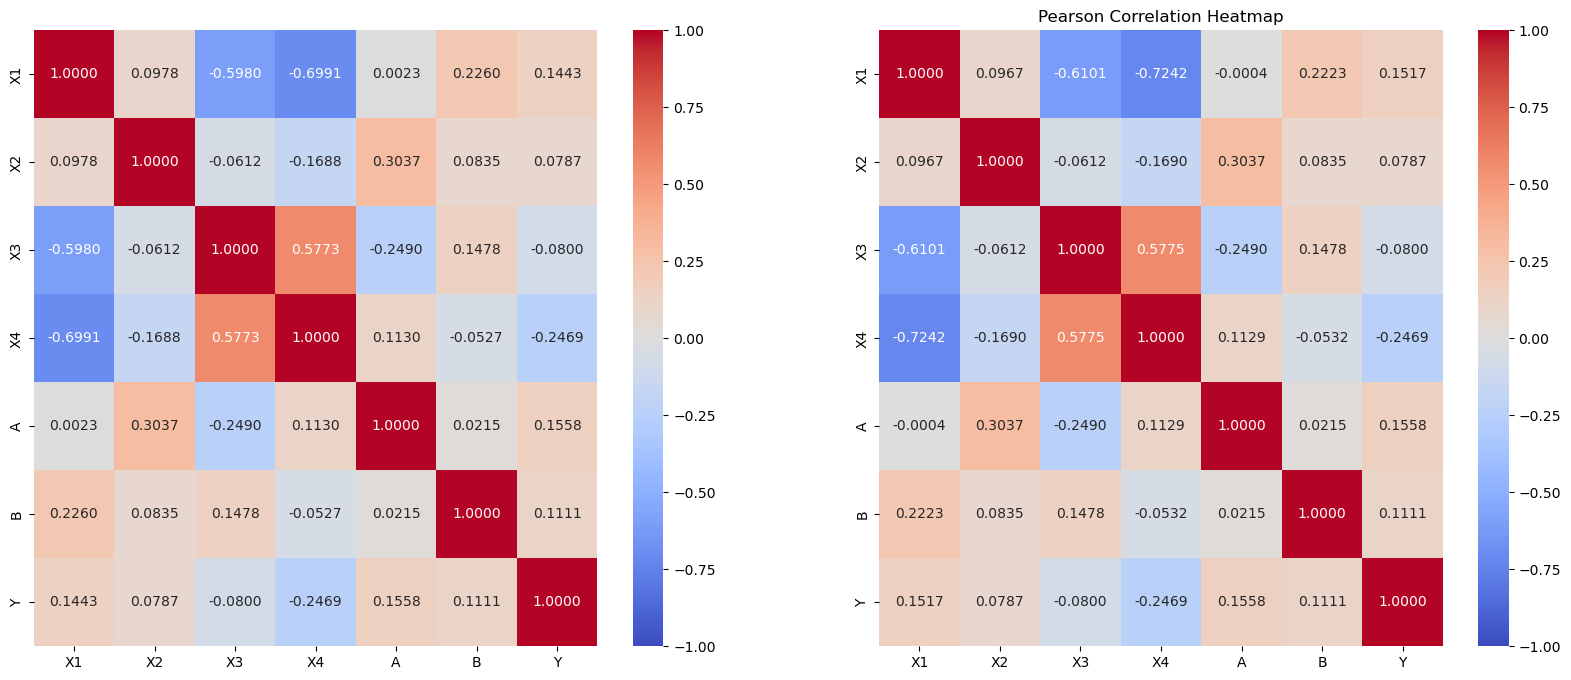

In [22]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [23]:
num_epochs = 30
predictor.train()

gradient_norms_pred = []
epochs_pred = []

In [24]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        predictor.zero_grad()
        x_recon = encoder(data)
        y_pred = predictor(x_recon.detach())
        lp = criterion_pred(y_pred, labels)
        lp.backward()
        
        batch_gradient_norm = 0.0
        for p in predictor.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_pred.step()
    
    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_pred.append(average_gradient_norm)
    epochs_pred.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Pred: {lp.item():.4f}')

Epoch [1/30], Loss Pred: 0.5527
Epoch [2/30], Loss Pred: 0.3975
Epoch [3/30], Loss Pred: 0.4873
Epoch [4/30], Loss Pred: 0.4783
Epoch [5/30], Loss Pred: 0.4891
Epoch [6/30], Loss Pred: 0.4107
Epoch [7/30], Loss Pred: 0.5278
Epoch [8/30], Loss Pred: 0.5512
Epoch [9/30], Loss Pred: 0.4900
Epoch [10/30], Loss Pred: 0.5818
Epoch [11/30], Loss Pred: 0.5022
Epoch [12/30], Loss Pred: 0.4976
Epoch [13/30], Loss Pred: 0.3898
Epoch [14/30], Loss Pred: 0.4591
Epoch [15/30], Loss Pred: 0.5023
Epoch [16/30], Loss Pred: 0.4683
Epoch [17/30], Loss Pred: 0.4060
Epoch [18/30], Loss Pred: 0.4894
Epoch [19/30], Loss Pred: 0.4408
Epoch [20/30], Loss Pred: 0.4405
Epoch [21/30], Loss Pred: 0.4477
Epoch [22/30], Loss Pred: 0.5628
Epoch [23/30], Loss Pred: 0.4775
Epoch [24/30], Loss Pred: 0.4666
Epoch [25/30], Loss Pred: 0.5101
Epoch [26/30], Loss Pred: 0.5239
Epoch [27/30], Loss Pred: 0.4758
Epoch [28/30], Loss Pred: 0.3866
Epoch [29/30], Loss Pred: 0.4687
Epoch [30/30], Loss Pred: 0.4467


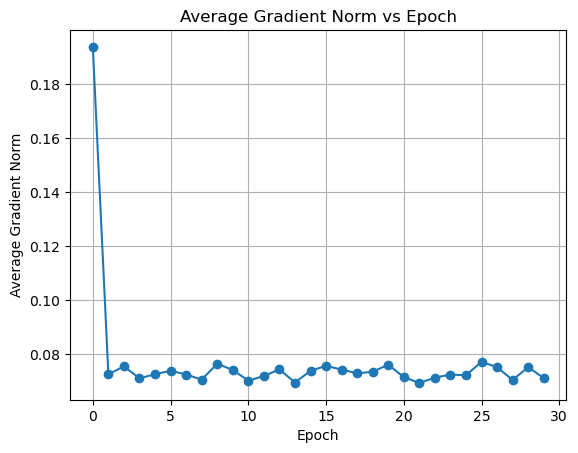

In [25]:
plt.plot(list(range(num_epochs)), gradient_norms_pred, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

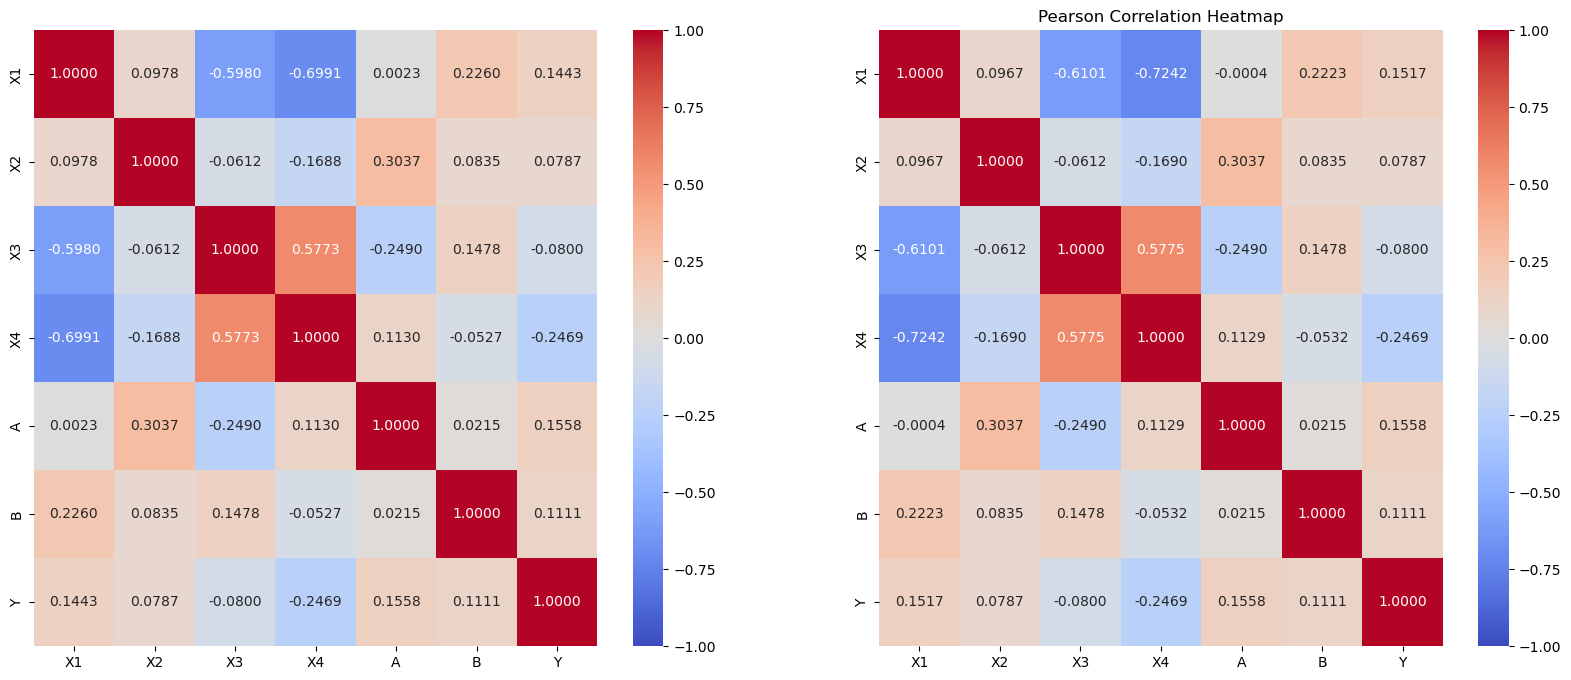

In [26]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [27]:
num_epochs = 30
adversaryA.train()

gradient_norms_advA = []
epochs_advA = []

In [28]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        adversaryA.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon.detach())
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laA.backward()
        
        batch_gradient_norm = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_advA.step()

    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_advA.append(average_gradient_norm)
    epochs_advA.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Adv A: {laA.item():.4f}')

Epoch [1/30], Loss Adv A: 0.5671
Epoch [2/30], Loss Adv A: 0.3993
Epoch [3/30], Loss Adv A: 0.4599
Epoch [4/30], Loss Adv A: 0.3921
Epoch [5/30], Loss Adv A: 0.4138
Epoch [6/30], Loss Adv A: 0.4456
Epoch [7/30], Loss Adv A: 0.4425
Epoch [8/30], Loss Adv A: 0.4756
Epoch [9/30], Loss Adv A: 0.5109
Epoch [10/30], Loss Adv A: 0.4160
Epoch [11/30], Loss Adv A: 0.4183
Epoch [12/30], Loss Adv A: 0.4838
Epoch [13/30], Loss Adv A: 0.4213
Epoch [14/30], Loss Adv A: 0.4642
Epoch [15/30], Loss Adv A: 0.3970
Epoch [16/30], Loss Adv A: 0.4723
Epoch [17/30], Loss Adv A: 0.4349
Epoch [18/30], Loss Adv A: 0.4323
Epoch [19/30], Loss Adv A: 0.4414
Epoch [20/30], Loss Adv A: 0.3868
Epoch [21/30], Loss Adv A: 0.4562
Epoch [22/30], Loss Adv A: 0.4353
Epoch [23/30], Loss Adv A: 0.4584
Epoch [24/30], Loss Adv A: 0.4297
Epoch [25/30], Loss Adv A: 0.4161
Epoch [26/30], Loss Adv A: 0.5059
Epoch [27/30], Loss Adv A: 0.4403
Epoch [28/30], Loss Adv A: 0.5434
Epoch [29/30], Loss Adv A: 0.3663
Epoch [30/30], Loss Adv

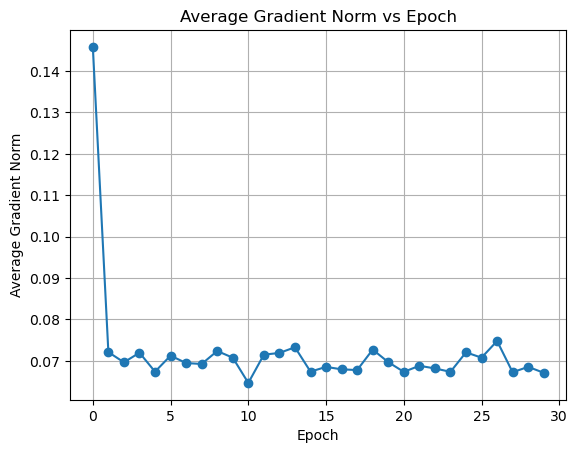

In [29]:
plt.plot(list(range(num_epochs)), gradient_norms_advA, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

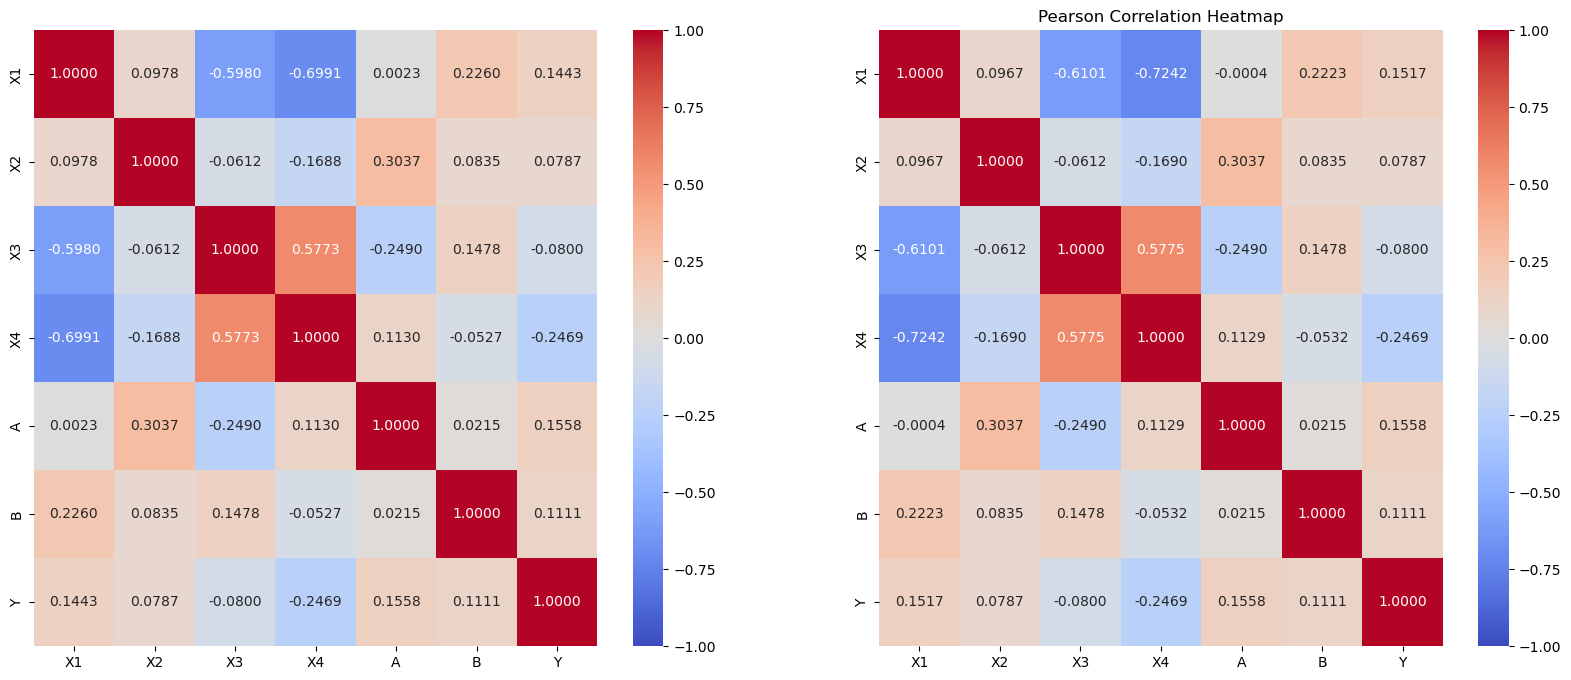

In [30]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [31]:
num_epochs = 30
adversaryB.train()

gradient_norms_advB = []
epochs_advB = []

In [32]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predB = adversaryB(x_recon.detach())
        laB = criterion_advB(adv_predB, data[:,4].view(-1,1).float())
        laB.backward()
        
        batch_gradient_norm = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_advB.step()

    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_advB.append(average_gradient_norm)
    epochs_advB.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Adv: {laB.item():.4f}')

Epoch [1/30], Loss Adv: 0.4368
Epoch [2/30], Loss Adv: 0.4270
Epoch [3/30], Loss Adv: 0.4761
Epoch [4/30], Loss Adv: 0.5776
Epoch [5/30], Loss Adv: 0.4533
Epoch [6/30], Loss Adv: 0.4788
Epoch [7/30], Loss Adv: 0.4168
Epoch [8/30], Loss Adv: 0.3817
Epoch [9/30], Loss Adv: 0.4402
Epoch [10/30], Loss Adv: 0.4830
Epoch [11/30], Loss Adv: 0.4427
Epoch [12/30], Loss Adv: 0.4645
Epoch [13/30], Loss Adv: 0.4953
Epoch [14/30], Loss Adv: 0.4511
Epoch [15/30], Loss Adv: 0.4721
Epoch [16/30], Loss Adv: 0.4622
Epoch [17/30], Loss Adv: 0.4460
Epoch [18/30], Loss Adv: 0.5183
Epoch [19/30], Loss Adv: 0.3905
Epoch [20/30], Loss Adv: 0.4436
Epoch [21/30], Loss Adv: 0.3964
Epoch [22/30], Loss Adv: 0.4391
Epoch [23/30], Loss Adv: 0.3487
Epoch [24/30], Loss Adv: 0.5100
Epoch [25/30], Loss Adv: 0.4704
Epoch [26/30], Loss Adv: 0.4248
Epoch [27/30], Loss Adv: 0.4615
Epoch [28/30], Loss Adv: 0.4245
Epoch [29/30], Loss Adv: 0.4962
Epoch [30/30], Loss Adv: 0.4814


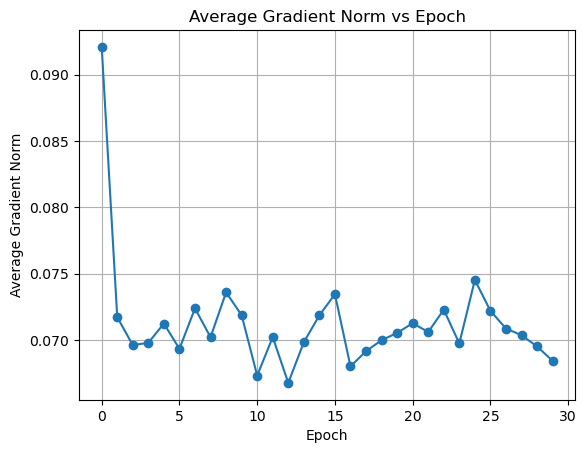

In [33]:
plt.plot(list(range(num_epochs)), gradient_norms_advB, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

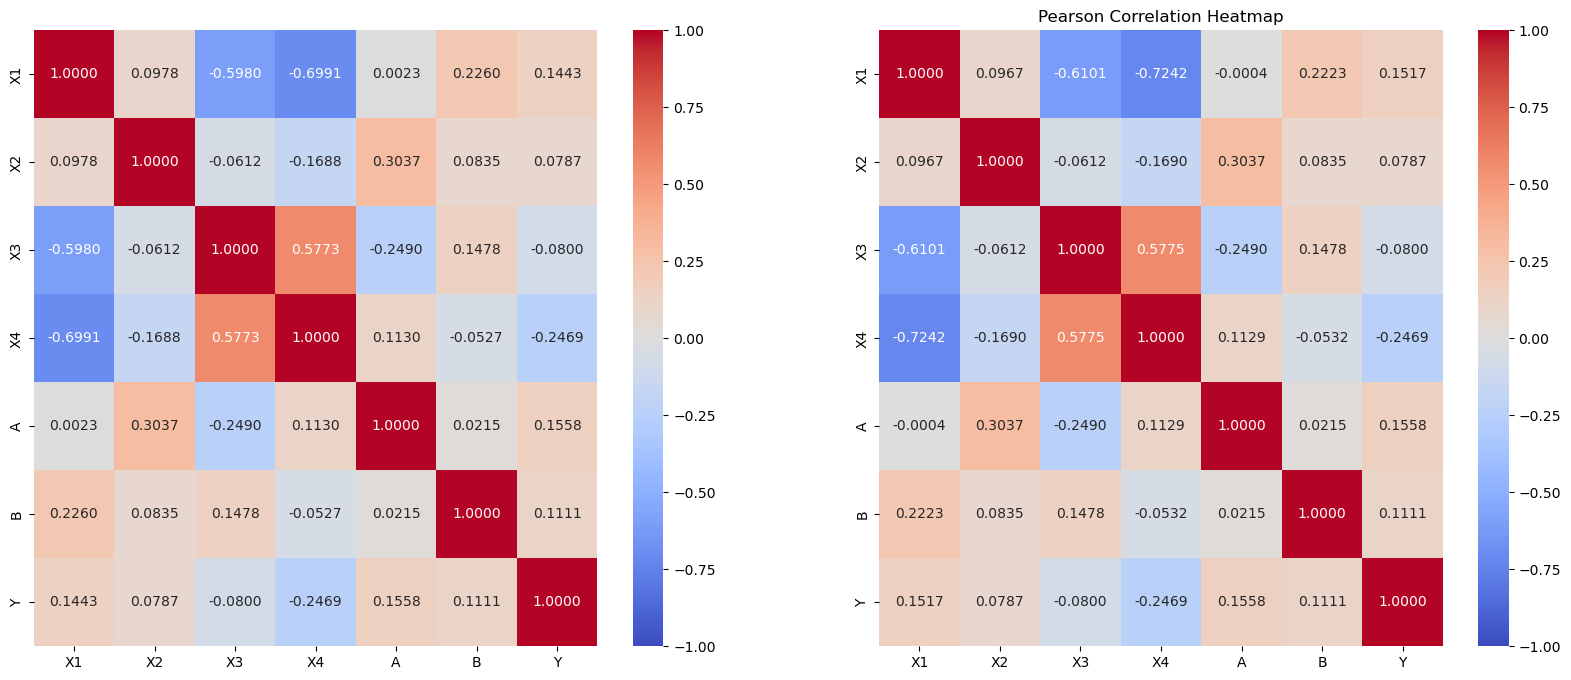

In [34]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [35]:
num_epochs = 250
encoder.train()
predictor.train()
adversaryA.train()
adversaryB.train()

gradient_norms_advA = []
gradient_norms_advB = []
gradient_norms_enc = []
gradient_norms_pred = []
epochs_total = []

In [36]:
for epoch in range(num_epochs):
    
    total_gradient_norm_A = 0.0
    total_gradient_norm_B = 0.0
    total_gradient_norm_enc = 0.0
    total_gradient_norm_pred = 0.0
    num_batches_adv = 0
    num_batches_other = 0

    for data, labels in dataloader: 
        adversaryA.zero_grad()
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon)
        adv_predB = adversaryB(x_recon)
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
        laA.backward(retain_graph=True)
        laB.backward()
        
        batch_gradient_norm_A = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
        total_gradient_norm_A += batch_gradient_norm_A

        batch_gradient_norm_B = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
        total_gradient_norm_B += batch_gradient_norm_B

        num_batches_adv += 1

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

        optimizer_advA.step()
        optimizer_advB.step()
        
    for data, labels in dataloader: 
        pass
    
    encoder.zero_grad()
    predictor.zero_grad()
    x_recon = encoder(data)
    y_pred = predictor(x_recon)
    adv_predA = adversaryA(x_recon)
    adv_predB = adversaryB(x_recon)

    lx = criterion_enc(x_recon, data[:,:4])
    lp = criterion_pred(y_pred, labels)
    laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
    laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
    
    combined_loss = lx + lp - (10 * (laA + laB))
#     combined_loss = lx + lp - (laA + laB)
    combined_loss.backward()

    for p in adversaryA.parameters():
        if p.grad is not None:
            batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
    total_gradient_norm_A += batch_gradient_norm_A
    
    for p in adversaryB.parameters():
        if p.grad is not None:
            batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
    total_gradient_norm_B += batch_gradient_norm_B

    batch_gradient_norm_enc = 0.0
    for p in encoder.parameters():
        if p.grad is not None:
            batch_gradient_norm_enc += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_enc = batch_gradient_norm_enc ** 0.5
    total_gradient_norm_enc += batch_gradient_norm_enc

    batch_gradient_norm_pred = 0.0
    for p in predictor.parameters():
        if p.grad is not None:
            batch_gradient_norm_pred += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_pred = batch_gradient_norm_pred ** 0.5
    total_gradient_norm_pred += batch_gradient_norm_pred


    num_batches_other += 1
    num_batches_adv += 1

    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

    optimizer_pred.step()
    optimizer_enc.step()

    
    average_gradient_norm_A = total_gradient_norm_A / num_batches_adv
    gradient_norms_advA.append(average_gradient_norm_A)

    average_gradient_norm_B = total_gradient_norm_B / num_batches_adv
    gradient_norms_advB.append(average_gradient_norm_B)
    
    average_gradient_norm_enc = total_gradient_norm_enc / num_batches_other
    gradient_norms_enc.append(average_gradient_norm_enc)

    average_gradient_norm_pred = total_gradient_norm_pred / num_batches_other
    gradient_norms_pred.append(average_gradient_norm_pred)

    epochs_total.append(epoch)

#     print("num_batches_adv",num_batches_adv)
#     print("num_batches_other",num_batches_other)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss A: {laA.item():.4f}, Loss B: {laB.item():.4f}, Loss Recon: {lx.item():.4f}, Loss P: {lp.item():.4f}, Loss Comb: {combined_loss.item():.4f}')

Epoch [1/250], Loss A: 0.4413, Loss B: 0.2469, Loss Recon: 0.0001, Loss P: 0.4835, Loss Comb: -6.3984
Epoch [2/250], Loss A: 0.5363, Loss B: 0.2534, Loss Recon: 0.0007, Loss P: 0.4846, Loss Comb: -7.4123
Epoch [3/250], Loss A: 0.4967, Loss B: 0.2185, Loss Recon: 0.0048, Loss P: 0.4495, Loss Comb: -6.6972
Epoch [4/250], Loss A: 0.5406, Loss B: 0.2036, Loss Recon: 0.0092, Loss P: 0.5123, Loss Comb: -6.9205
Epoch [5/250], Loss A: 0.5456, Loss B: 0.2776, Loss Recon: 0.0156, Loss P: 0.3814, Loss Comb: -7.8349
Epoch [6/250], Loss A: 0.5617, Loss B: 0.2870, Loss Recon: 0.0214, Loss P: 0.4764, Loss Comb: -7.9894
Epoch [7/250], Loss A: 0.6297, Loss B: 0.3174, Loss Recon: 0.0298, Loss P: 0.4353, Loss Comb: -9.0065
Epoch [8/250], Loss A: 0.4991, Loss B: 0.2249, Loss Recon: 0.0204, Loss P: 0.4851, Loss Comb: -6.7345
Epoch [9/250], Loss A: 0.5860, Loss B: 0.2982, Loss Recon: 0.0239, Loss P: 0.4814, Loss Comb: -8.3370
Epoch [10/250], Loss A: 0.5262, Loss B: 0.2167, Loss Recon: 0.0310, Loss P: 0.4602

In [37]:
len(epochs_total)

250

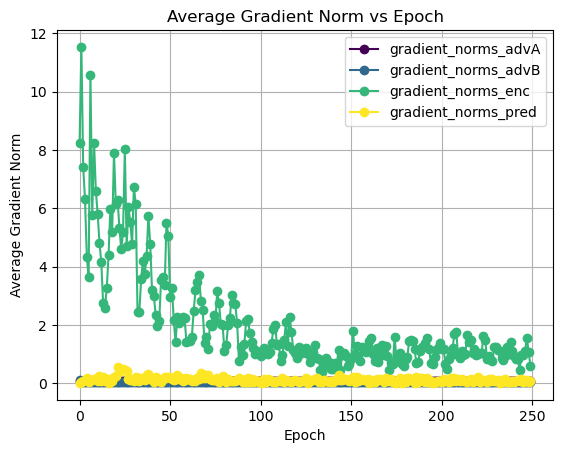

In [38]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

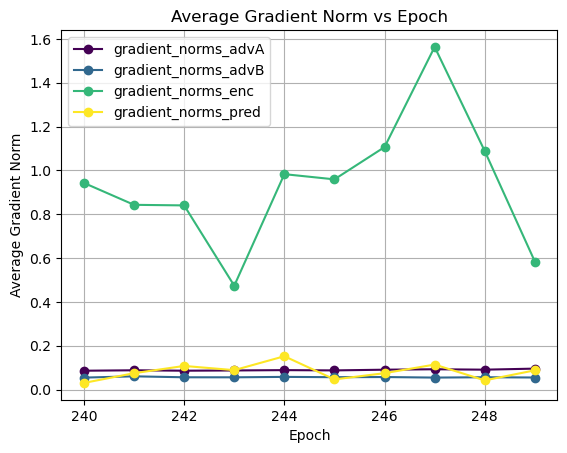

In [39]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advA[-10:], color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advB[-10:], color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_enc[-10:], color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_pred[-10:], color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

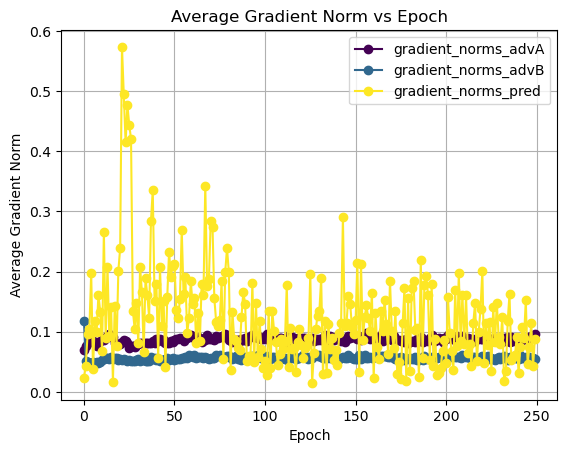

In [40]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
# plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [48]:
# index = 0
# df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
# df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B_Y], axis=1)
# correlation_matrix = df.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

In [41]:
index = 0
df_original = datasets[index].copy()

dataset = CustomDataset(df_original)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

encoder_outputs = []
encoder.eval()
with torch.no_grad():
    for batch_X, _ in dataloader:
        output = encoder(batch_X)
        encoder_outputs.append(output)
encoder_outputs = torch.cat(encoder_outputs, dim=0)
print(encoder_outputs.shape)

encoder_outputs_np = encoder_outputs.numpy()
df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B], axis=1)

correlation_matrix = df.corr()

torch.Size([100000, 4])


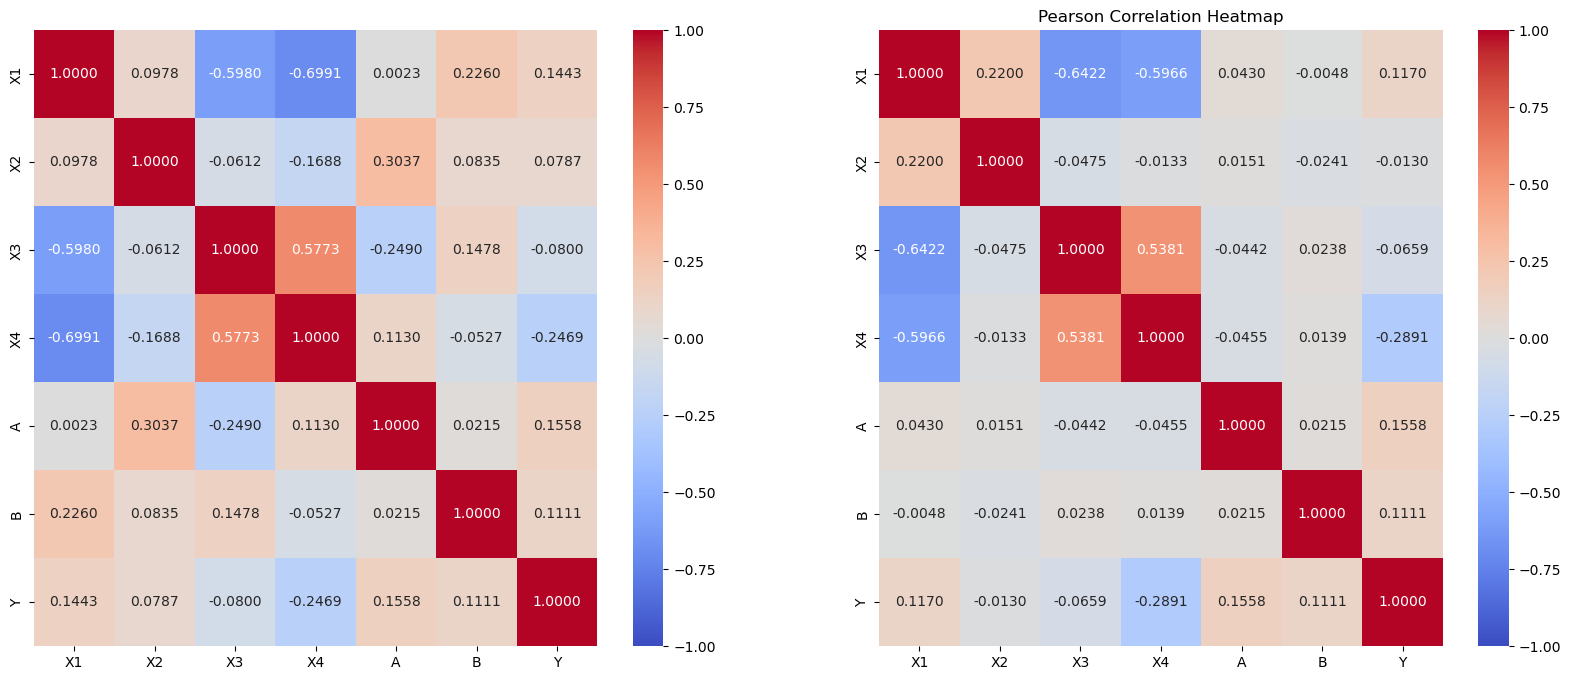

In [42]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [122]:
def accu_over_thresh(index=0, th = 0.5):
    df = datasets[0].copy()
    encoder.eval()
    predictor.eval()
    x_recon = encoder(torch.tensor(df[['X1', 'X2', 'X3', 'X4', 'A', 'B']].values, dtype=torch.float32)).detach()
    df['Y_pred'] = predictor(x_recon).detach().numpy()
    threshold = th
    df['Y_pred_binary'] = (df['Y_pred'] >= threshold).astype(int)

    TP = ((df['Y'] == 1) & (df['Y_pred_binary'] == 1)).sum()
    TN = ((df['Y'] == 0) & (df['Y_pred_binary'] == 0)).sum()
    FP = ((df['Y'] == 0) & (df['Y_pred_binary'] == 1)).sum()
    FN = ((df['Y'] == 1) & (df['Y_pred_binary'] == 0)).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

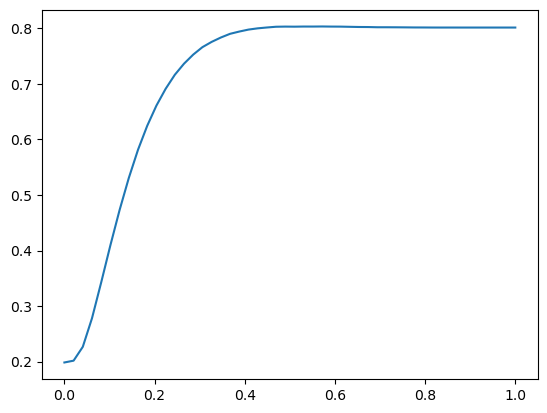

In [123]:
accs = [accu_over_thresh(th = t) for t in np.linspace(0,1,num=50)]
plt.plot(np.linspace(0,1,num=50),accs)

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

index = 0
y_true = datasets[index]['Y'].values
y_logits = predictor(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach()).detach().numpy().reshape(-1)
y_pred = (y_logits > 0.5).astype(int)
sf_dataA = datasets[index]['A'].values
sf_dataB = datasets[index]['B'].values

accuracy = np.mean(y_true == y_pred)
auc_score = roc_auc_score(y_true, y_logits)

print(f'Accuracy: {accuracy:.4f}')
print(f'auc_score: {auc_score:.4f}') 

df = pd.DataFrame({
    'y_true': y_true,
    
    'y_pred': y_pred,
    'sf_dataA': sf_dataA,
    'sf_dataB': sf_dataB
})

group_statsA = df.groupby('sf_dataA').agg(
    total_predictions=('y_pred', 'size'),
    positive_predictions=('y_pred', 'sum')
)
group_statsA['positive_prediction_rate'] = group_statsA['positive_predictions'] / group_statsA['total_predictions']

# Calculate demographic parity
demographic_parityA = group_statsA['positive_prediction_rate'].max() - group_statsA['positive_prediction_rate'].min()

print("group_statsA", group_statsA)
print("Demographic Parity A:", demographic_parityA)

group_statsB = df.groupby('sf_dataB').agg(
    total_predictions=('y_pred', 'size'),
    positive_predictions=('y_pred', 'sum')
)
group_statsB['positive_prediction_rate'] = group_statsB['positive_predictions'] / group_statsB['total_predictions']

# Calculate demographic parity
demographic_parityB = group_statsB['positive_prediction_rate'].max() - group_statsB['positive_prediction_rate'].min()

print("group_statsB", group_statsB)
print("Demographic Parity B:", demographic_parityB)

Accuracy: 0.8023
auc_score: 0.7161
group_statsA           total_predictions  positive_predictions  positive_prediction_rate
sf_dataA                                                                   
0                     70075                  2319                  0.033093
1                     29925                  1071                  0.035789
Demographic Parity A: 0.002696359164053551
group_statsB           total_predictions  positive_predictions  positive_prediction_rate
sf_dataB                                                                   
0                     10017                   354                   0.03534
1                     89983                  3036                   0.03374
Demographic Parity B: 0.0016002157433903721


In [187]:
encoder = Encoder(6)
predictor = Predictor(4)
adversaryA = Adversary(4)
adversaryB = Adversary(4)

In [188]:
learning_rate = 0.01

criterion_enc = nn.MSELoss()
criterion_pred = nn.BCELoss()
criterion_advA = nn.L1Loss()
criterion_advB = nn.L1Loss()

optimizer_pred = optim.Adam(predictor.parameters(), lr=learning_rate)
optimizer_advA = optim.Adam(adversaryA.parameters(), lr=learning_rate)
optimizer_advB = optim.Adam(adversaryB.parameters(), lr=learning_rate)
optimizer_enc = optim.Adam(encoder.parameters(), lr=learning_rate)

In [189]:
num_epochs = 50
encoder.train()
predictor.train()
adversaryA.train()
adversaryB.train()

gradient_norms_advA = []
gradient_norms_advB = []
gradient_norms_enc = []
gradient_norms_pred = []
epochs_total = []

In [217]:
for epoch in range(num_epochs):
    
    total_gradient_norm_A = 0.0
    total_gradient_norm_B = 0.0
    total_gradient_norm_enc = 0.0
    total_gradient_norm_pred = 0.0
    num_batches_adv = 0
    num_batches_other = 0

    for data, labels in dataloader: 
        
        A = data[:,4].view(-1,1).float()
        len_A0Y0 = ((A == 0) & (labels == 0)).sum().item()
        len_A0Y1 = ((A == 0) & (labels == 1)).sum().item()
        len_A1Y0 = ((A == 1) & (labels == 0)).sum().item()
        len_A1Y1 = ((A == 1) & (labels == 1)).sum().item()
        total_length = len_A0Y0 + len_A0Y1 + len_A1Y0 + len_A1Y1
        A0Y0 = len_A0Y0 / total_length
        A0Y1 = len_A0Y1 / total_length
        A1Y0 = len_A1Y0 / total_length
        A1Y1 = len_A1Y1 / total_length
        AY_proportion = [[A0Y0, A0Y1], [A1Y0, A1Y1]]
        A_prop = [AY_proportion[0][0] + AY_proportion[0][1], AY_proportion[1][0] + AY_proportion[1][1]]
        Y_prop = [AY_proportion[0][0] + AY_proportion[1][0], AY_proportion[0][1] + AY_proportion[1][1]]
        wtsA = A_prop[0] * (1 - A) + A_prop[1] * A

        A = data[:,5].view(-1,1).float()
        len_A0Y0 = ((A == 0) & (labels == 0)).sum().item()
        len_A0Y1 = ((A == 0) & (labels == 1)).sum().item()
        len_A1Y0 = ((A == 1) & (labels == 0)).sum().item()
        len_A1Y1 = ((A == 1) & (labels == 1)).sum().item()
        total_length = len_A0Y0 + len_A0Y1 + len_A1Y0 + len_A1Y1
        A0Y0 = len_A0Y0 / total_length
        A0Y1 = len_A0Y1 / total_length
        A1Y0 = len_A1Y0 / total_length
        A1Y1 = len_A1Y1 / total_length
        AY_proportion = [[A0Y0, A0Y1], [A1Y0, A1Y1]]
        A_prop = [AY_proportion[0][0] + AY_proportion[0][1], AY_proportion[1][0] + AY_proportion[1][1]]
        Y_prop = [AY_proportion[0][0] + AY_proportion[1][0], AY_proportion[0][1] + AY_proportion[1][1]]
        wtsB = A_prop[0] * (1 - A) + A_prop[1] * A
        
        adversaryA.zero_grad()
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon)
        adv_predB = adversaryB(x_recon)
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())

        weighted_aud_lossA = torch.mean(laA * torch.squeeze(wtsA))
        weighted_aud_lossB = torch.mean(laB * torch.squeeze(wtsB))

        weighted_aud_lossA.backward(retain_graph=True)
        weighted_aud_lossB.backward()
        
        batch_gradient_norm_A = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
        total_gradient_norm_A += batch_gradient_norm_A

        batch_gradient_norm_B = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
        total_gradient_norm_B += batch_gradient_norm_B

        num_batches_adv += 1

#         torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

        optimizer_advA.step()
        optimizer_advB.step()
        
    for data, labels in dataloader: 
        pass

    A = data[:,4].view(-1,1).float()
    len_A0Y0 = ((A == 0) & (labels == 0)).sum().item()
    len_A0Y1 = ((A == 0) & (labels == 1)).sum().item()
    len_A1Y0 = ((A == 1) & (labels == 0)).sum().item()
    len_A1Y1 = ((A == 1) & (labels == 1)).sum().item()
    total_length = len_A0Y0 + len_A0Y1 + len_A1Y0 + len_A1Y1
    A0Y0 = len_A0Y0 / total_length
    A0Y1 = len_A0Y1 / total_length
    A1Y0 = len_A1Y0 / total_length
    A1Y1 = len_A1Y1 / total_length
    AY_proportion = [[A0Y0, A0Y1], [A1Y0, A1Y1]]
    A_prop = [AY_proportion[0][0] + AY_proportion[0][1], AY_proportion[1][0] + AY_proportion[1][1]]
    Y_prop = [AY_proportion[0][0] + AY_proportion[1][0], AY_proportion[0][1] + AY_proportion[1][1]]
    wtsA = A_prop[0] * (1 - A) + A_prop[1] * A

    A = data[:,5].view(-1,1).float()
    len_A0Y0 = ((A == 0) & (labels == 0)).sum().item()
    len_A0Y1 = ((A == 0) & (labels == 1)).sum().item()
    len_A1Y0 = ((A == 1) & (labels == 0)).sum().item()
    len_A1Y1 = ((A == 1) & (labels == 1)).sum().item()
    total_length = len_A0Y0 + len_A0Y1 + len_A1Y0 + len_A1Y1
    A0Y0 = len_A0Y0 / total_length
    A0Y1 = len_A0Y1 / total_length
    A1Y0 = len_A1Y0 / total_length
    A1Y1 = len_A1Y1 / total_length
    AY_proportion = [[A0Y0, A0Y1], [A1Y0, A1Y1]]
    A_prop = [AY_proportion[0][0] + AY_proportion[0][1], AY_proportion[1][0] + AY_proportion[1][1]]
    Y_prop = [AY_proportion[0][0] + AY_proportion[1][0], AY_proportion[0][1] + AY_proportion[1][1]]
    wtsB = A_prop[0] * (1 - A) + A_prop[1] * A

    encoder.zero_grad()
    predictor.zero_grad()
    x_recon = encoder(data)
    y_pred = predictor(x_recon)
    adv_predA = adversaryA(x_recon)
    adv_predB = adversaryB(x_recon)

    lx = criterion_enc(x_recon, data[:,:4])
    lp = criterion_pred(y_pred, labels)
    laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
    laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
    weighted_aud_lossA = torch.mean(laA * torch.squeeze(wtsA))
    weighted_aud_lossB = torch.mean(laB * torch.squeeze(wtsB))

    combined_loss = lx + lp - (10 * (weighted_aud_lossA + weighted_aud_lossB))
#     combined_loss = lx + lp - (laA + laB)
    combined_loss.backward()

    for p in adversaryA.parameters():
        if p.grad is not None:
            batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
    total_gradient_norm_A += batch_gradient_norm_A
    
    for p in adversaryB.parameters():
        if p.grad is not None:
            batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
    total_gradient_norm_B += batch_gradient_norm_B

    batch_gradient_norm_enc = 0.0
    for p in encoder.parameters():
        if p.grad is not None:
            batch_gradient_norm_enc += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_enc = batch_gradient_norm_enc ** 0.5
    total_gradient_norm_enc += batch_gradient_norm_enc

    batch_gradient_norm_pred = 0.0
    for p in predictor.parameters():
        if p.grad is not None:
            batch_gradient_norm_pred += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_pred = batch_gradient_norm_pred ** 0.5
    total_gradient_norm_pred += batch_gradient_norm_pred


    num_batches_other += 1
    num_batches_adv += 1

#     torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

    optimizer_pred.step()
    optimizer_enc.step()

    
    average_gradient_norm_A = total_gradient_norm_A / num_batches_adv
    gradient_norms_advA.append(average_gradient_norm_A)

    average_gradient_norm_B = total_gradient_norm_B / num_batches_adv
    gradient_norms_advB.append(average_gradient_norm_B)
    
    average_gradient_norm_enc = total_gradient_norm_enc / num_batches_other
    gradient_norms_enc.append(average_gradient_norm_enc)

    average_gradient_norm_pred = total_gradient_norm_pred / num_batches_other
    gradient_norms_pred.append(average_gradient_norm_pred)

    epochs_total.append(epoch)

#     print("num_batches_adv",num_batches_adv)
#     print("num_batches_other",num_batches_other)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss A: {laA.item():.4f}, Loss B: {laB.item():.4f}, Loss Recon: {lx.item():.4f}, Loss P: {lp.item():.4f}, Loss Comb: {combined_loss.item():.4f}')

Epoch [1/50], Loss A: 0.3625, Loss B: 0.0639, Loss Recon: 0.3354, Loss P: 0.5256, Loss Comb: -1.6461
Epoch [2/50], Loss A: 0.3625, Loss B: 0.0640, Loss Recon: 0.3249, Loss P: 0.5251, Loss Comb: -1.6579
Epoch [3/50], Loss A: 0.3625, Loss B: 0.0641, Loss Recon: 0.3137, Loss P: 0.5246, Loss Comb: -1.6702
Epoch [4/50], Loss A: 0.3625, Loss B: 0.0641, Loss Recon: 0.3019, Loss P: 0.5241, Loss Comb: -1.6827
Epoch [5/50], Loss A: 0.3625, Loss B: 0.0641, Loss Recon: 0.2896, Loss P: 0.5235, Loss Comb: -1.6951
Epoch [6/50], Loss A: 0.3625, Loss B: 0.0640, Loss Recon: 0.2773, Loss P: 0.5230, Loss Comb: -1.7074
Epoch [7/50], Loss A: 0.3625, Loss B: 0.0639, Loss Recon: 0.2649, Loss P: 0.5225, Loss Comb: -1.7195
Epoch [8/50], Loss A: 0.3625, Loss B: 0.0638, Loss Recon: 0.2528, Loss P: 0.5221, Loss Comb: -1.7312
Epoch [9/50], Loss A: 0.3625, Loss B: 0.0637, Loss Recon: 0.2412, Loss P: 0.5218, Loss Comb: -1.7421
Epoch [10/50], Loss A: 0.3625, Loss B: 0.0636, Loss Recon: 0.2301, Loss P: 0.5216, Loss Com

In [218]:
len(epochs_total)

150

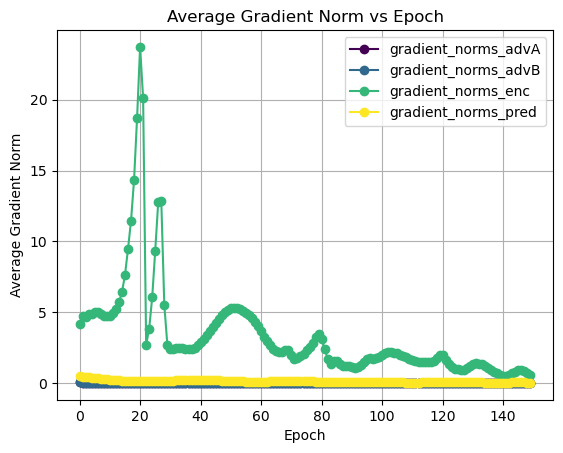

In [219]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

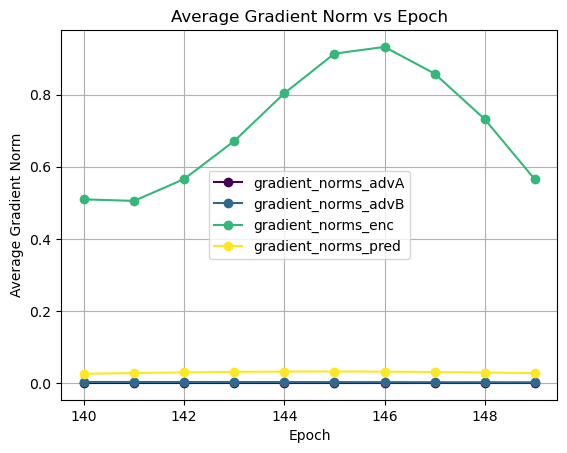

In [220]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advA[-10:], color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advB[-10:], color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_enc[-10:], color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_pred[-10:], color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

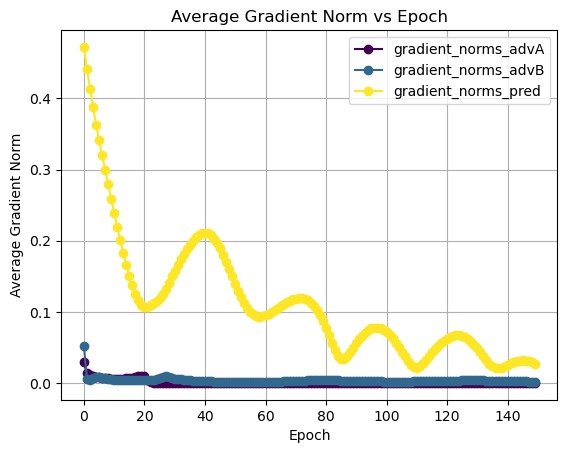

In [221]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
# plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [205]:
# index = 0
# df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
# df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B_Y], axis=1)
# correlation_matrix = df.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

In [224]:
index = 0
df_original = datasets[index].copy()

dataset = CustomDataset(df_original)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

encoder_outputs = []
encoder.eval()
with torch.no_grad():
    for batch_X, _ in dataloader:
        output = encoder(batch_X)
        encoder_outputs.append(output)
encoder_outputs = torch.cat(encoder_outputs, dim=0)
print(encoder_outputs.shape)

encoder_outputs_np = encoder_outputs.numpy()
df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B], axis=1)

correlation_matrix = df.corr()

torch.Size([100000, 4])


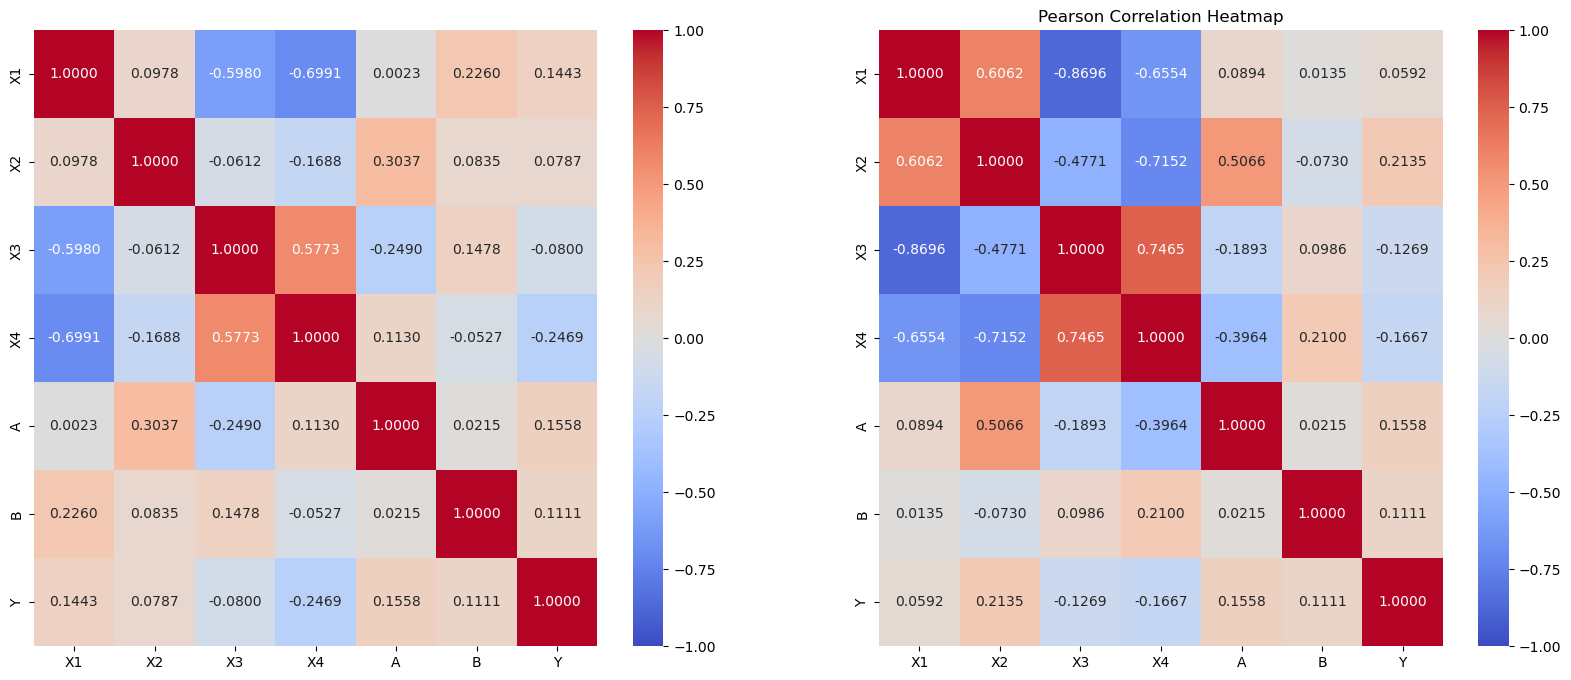

In [225]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

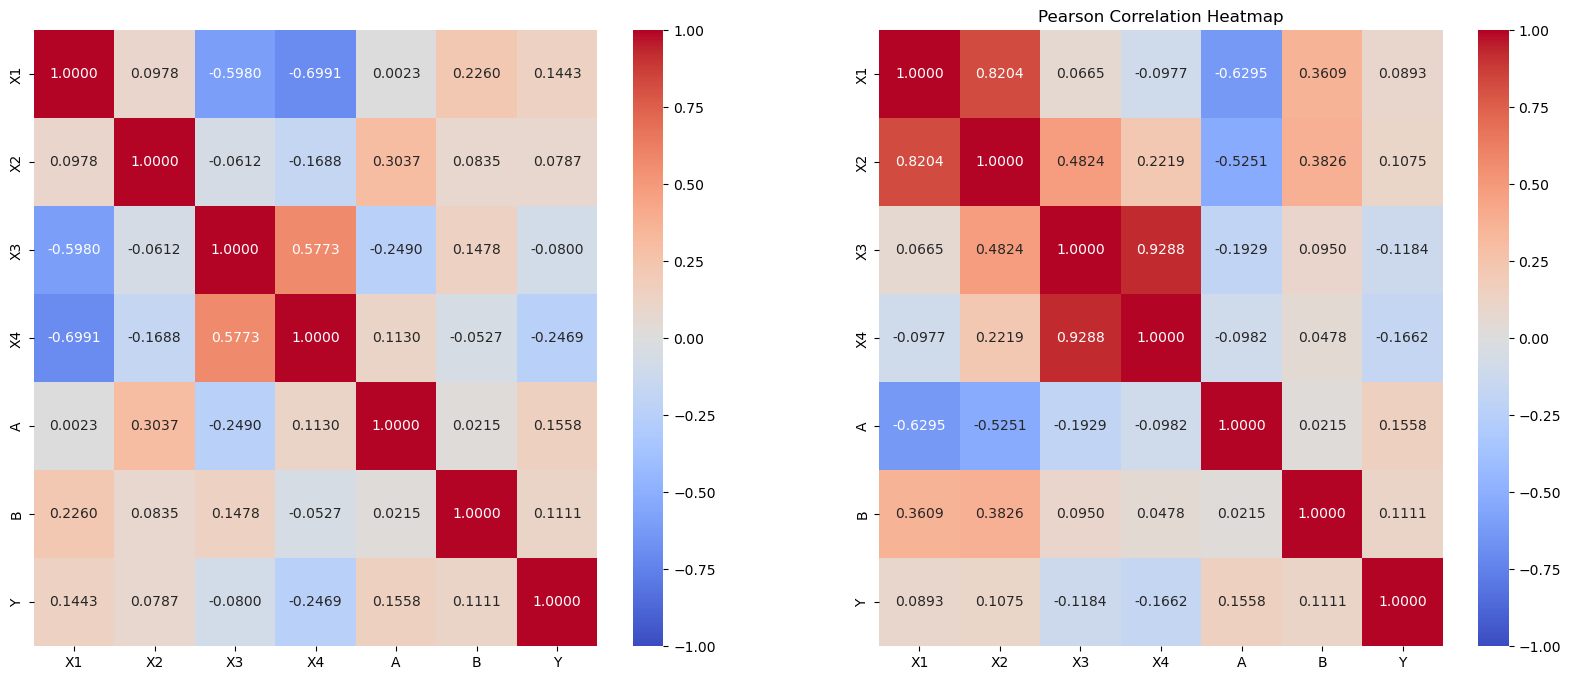

In [169]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

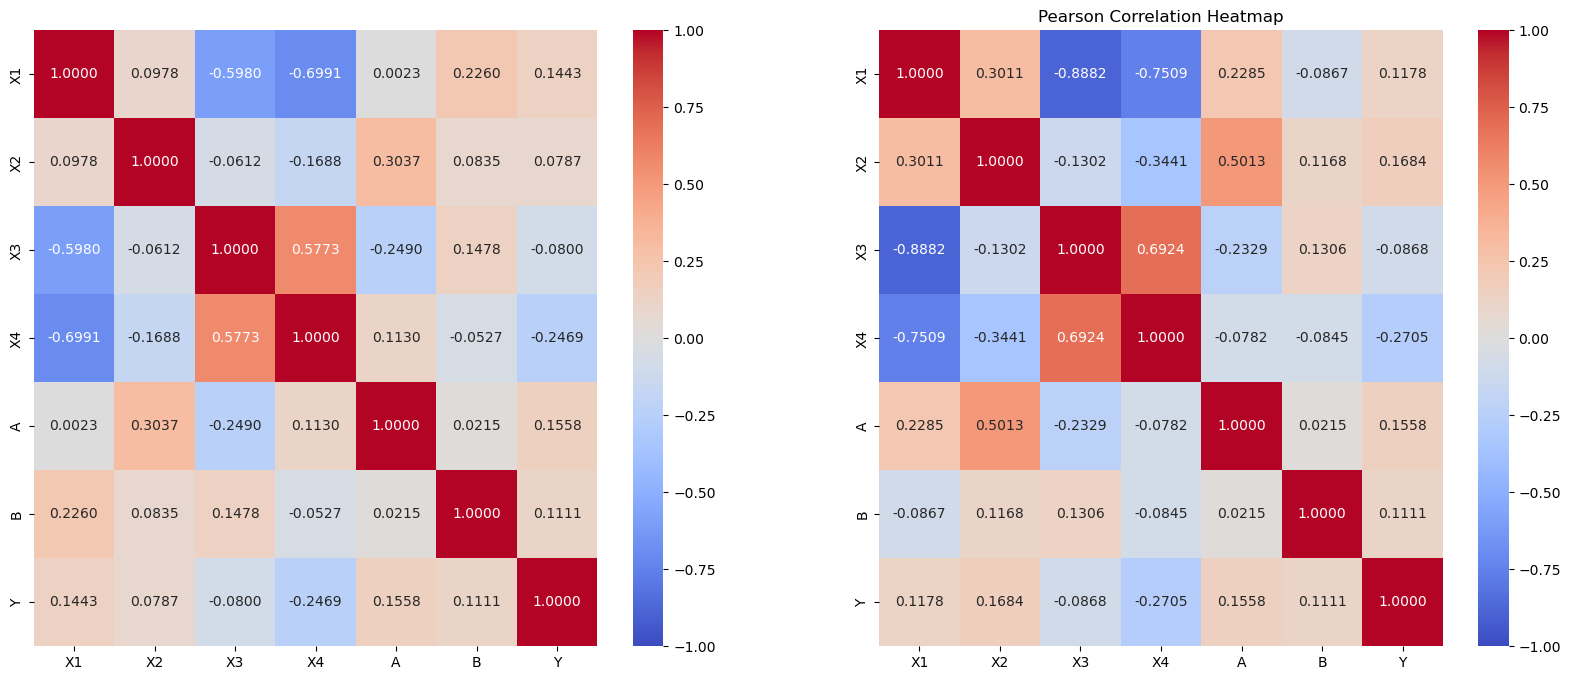

In [102]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

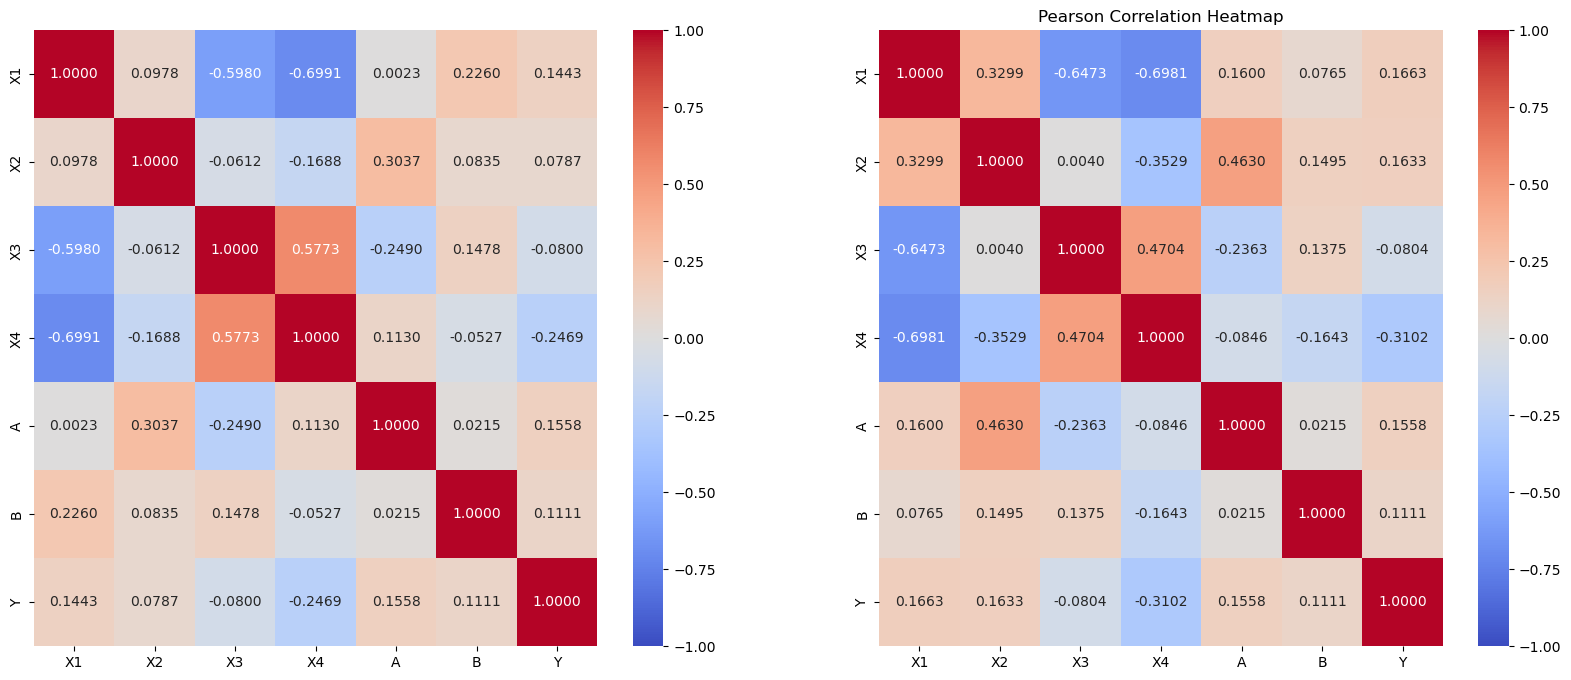

In [115]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [228]:
def accu_over_thresh(index=0, th = 0.5):
    df = datasets[0].copy()
    encoder.eval()
    predictor.eval()
    x_recon = encoder(torch.tensor(df[['X1', 'X2', 'X3', 'X4', 'A', 'B']].values, dtype=torch.float32)).detach()
    df['Y_pred'] = predictor(x_recon).detach().numpy()
    threshold = th
    df['Y_pred_binary'] = (df['Y_pred'] >= threshold).astype(int)

    TP = ((df['Y'] == 1) & (df['Y_pred_binary'] == 1)).sum()
    TN = ((df['Y'] == 0) & (df['Y_pred_binary'] == 0)).sum()
    FP = ((df['Y'] == 0) & (df['Y_pred_binary'] == 1)).sum()
    FN = ((df['Y'] == 1) & (df['Y_pred_binary'] == 0)).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

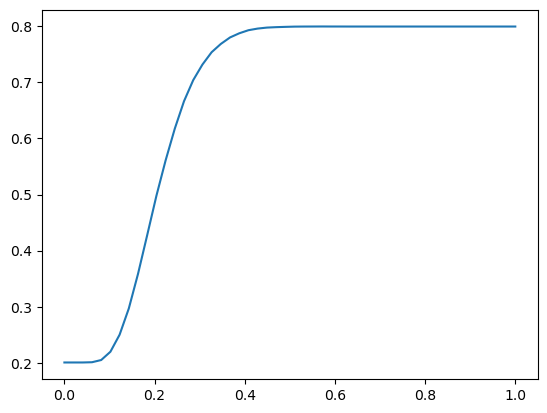

In [229]:
accs = [accu_over_thresh(th = t) for t in np.linspace(0,1,num=50)]
plt.plot(np.linspace(0,1,num=50),accs)

In [230]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

index = 0
y_true = datasets[index]['Y'].values
y_logits = predictor(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach()).detach().numpy().reshape(-1)
y_pred = (y_logits > 0.5).astype(int)
sf_dataA = datasets[index]['A'].values
sf_dataB = datasets[index]['B'].values

print(np.unique(y_pred, return_counts=True))
accuracy = np.mean(y_true == y_pred)
auc_score = roc_auc_score(y_true, y_logits)

print(f'Accuracy: {accuracy:.4f}')
print(f'auc_score: {auc_score:.4f}') 

df = pd.DataFrame({
    'y_true': y_true,
    
    'y_pred': y_pred,
    'sf_dataA': sf_dataA,
    'sf_dataB': sf_dataB
})

group_statsA = df.groupby('sf_dataA').agg(
    total_predictions=('y_pred', 'size'),
    positive_predictions=('y_pred', 'sum')
)
group_statsA['positive_prediction_rate'] = group_statsA['positive_predictions'] / group_statsA['total_predictions']

# Calculate demographic parity
demographic_parityA = group_statsA['positive_prediction_rate'].max() - group_statsA['positive_prediction_rate'].min()

print("group_statsA", group_statsA)
print("Demographic Parity A:", demographic_parityA)

group_statsB = df.groupby('sf_dataB').agg(
    total_predictions=('y_pred', 'size'),
    positive_predictions=('y_pred', 'sum')
)
group_statsB['positive_prediction_rate'] = group_statsB['positive_predictions'] / group_statsB['total_predictions']

# Calculate demographic parity
demographic_parityB = group_statsB['positive_prediction_rate'].max() - group_statsB['positive_prediction_rate'].min()

print("group_statsB", group_statsB)
print("Demographic Parity B:", demographic_parityB)

(array([0, 1]), array([99574,   426]))
Accuracy: 0.7988
auc_score: 0.6273
group_statsA           total_predictions  positive_predictions  positive_prediction_rate
sf_dataA                                                                   
0                     70075                   108                  0.001541
1                     29925                   318                  0.010627
Demographic Parity A: 0.009085360565166036
group_statsB           total_predictions  positive_predictions  positive_prediction_rate
sf_dataB                                                                   
0                     10017                   131                  0.013078
1                     89983                   295                  0.003278
Demographic Parity B: 0.009799370764198713


In [170]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

index = 0
y_true = datasets[index]['Y'].values
y_logits = predictor(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach()).detach().numpy().reshape(-1)
y_pred = (y_logits > 0.2).astype(int)
sf_dataA = datasets[index]['A'].values
sf_dataB = datasets[index]['B'].values

print(np.unique(y_pred, return_counts=True))
accuracy = np.mean(y_true == y_pred)
auc_score = roc_auc_score(y_true, y_logits)

print(f'Accuracy: {accuracy:.4f}')
print(f'auc_score: {auc_score:.4f}') 

df = pd.DataFrame({
    'y_true': y_true,
    
    'y_pred': y_pred,
    'sf_dataA': sf_dataA,
    'sf_dataB': sf_dataB
})

group_statsA = df.groupby('sf_dataA').agg(
    total_predictions=('y_pred', 'size'),
    positive_predictions=('y_pred', 'sum')
)
group_statsA['positive_prediction_rate'] = group_statsA['positive_predictions'] / group_statsA['total_predictions']

# Calculate demographic parity
demographic_parityA = group_statsA['positive_prediction_rate'].max() - group_statsA['positive_prediction_rate'].min()

print("group_statsA", group_statsA)
print("Demographic Parity A:", demographic_parityA)

group_statsB = df.groupby('sf_dataB').agg(
    total_predictions=('y_pred', 'size'),
    positive_predictions=('y_pred', 'sum')
)
group_statsB['positive_prediction_rate'] = group_statsB['positive_predictions'] / group_statsB['total_predictions']

# Calculate demographic parity
demographic_parityB = group_statsB['positive_prediction_rate'].max() - group_statsB['positive_prediction_rate'].min()

print("group_statsB", group_statsB)
print("Demographic Parity B:", demographic_parityB)

(array([0, 1]), array([32661, 67339]))
Accuracy: 0.4516
auc_score: 0.6410
group_statsA           total_predictions  positive_predictions  positive_prediction_rate
sf_dataA                                                                   
0                     70075                 46909                  0.669411
1                     29925                 20430                  0.682707
Demographic Parity A: 0.013295421929779838
group_statsB           total_predictions  positive_predictions  positive_prediction_rate
sf_dataB                                                                   
0                     10017                  6261                  0.625037
1                     89983                 61078                  0.678773
Demographic Parity B: 0.05373522069925307


In [173]:
for epoch in range(num_epochs):
    
    for data, labels in dataloader:
        A = data[:,-1].view(-1,1).float()
        len_A0Y0 = ((A == 0) & (labels == 0)).sum().item()
        len_A0Y1 = ((A == 0) & (labels == 1)).sum().item()
        len_A1Y0 = ((A == 1) & (labels == 0)).sum().item()
        len_A1Y1 = ((A == 1) & (labels == 1)).sum().item()
        
        total_length = len_A0Y0 + len_A0Y1 + len_A1Y0 + len_A1Y1

        A0Y0 = len_A0Y0 / total_length
        A0Y1 = len_A0Y1 / total_length
        A1Y0 = len_A1Y0 / total_length
        A1Y1 = len_A1Y1 / total_length
        
        AY_proportion = [[A0Y0, A0Y1], [A1Y0, A1Y1]]
        A_prop = [AY_proportion[0][0] + AY_proportion[0][1], AY_proportion[1][0] + AY_proportion[1][1]]
        Y_prop = [AY_proportion[0][0] + AY_proportion[1][0], AY_proportion[0][1] + AY_proportion[1][1]]

        wts = A_prop[0] * (1 - A) + A_prop[1] * A
#         print(f"len_A0Y0: {len_A0Y0}")
#         print(f"len_A0Y1: {len_A0Y1}")
#         print(f"len_A1Y0: {len_A1Y0}")
#         print(f"len_A1Y1: {len_A1Y1}")
#         print(f"Sum of all lengths: {total_length}")
#         print(f"AY_proportion: {AY_proportion}")
#         print(f"A_prop: {A_prop}")
#         print(f"Y_prop: {Y_prop}")
#         print(f"wts: {wts.shape}")
        
        torch.autograd.set_detect_anomaly(True)
        
        x_recon = encoder(data)
        y_pred = predictor(x_recon)
        adv_pred = adversaryA(x_recon)
        
        recon_loss = criterion_enc(x_recon, data[:,:4])
        
#         class_loss = class_coeff * criterion_pred(y_pred, labels)
        class_loss = 5 * criterion_pred(y_pred, labels)
#         aud_loss = -fair_coeff * criterion_adv(A, A_logits)
        aud_loss = -5 * criterion_advA(adv_pred, A)
    
        weighted_aud_loss = torch.mean(aud_loss * torch.squeeze(wts))

        loss = recon_loss + class_loss + weighted_aud_loss
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters())+list(predictor.parameters()), 5.0)
        optimizer.step()
        
        aud_steps = 30
        for i in range(aud_steps):
            optimizer_adv.zero_grad()
            x_recon = encoder(data)
            y_pred = predictor(x_recon)
            adv_pred = adversary(x_recon)

            recon_loss = criterion_enc(x_recon, data[:,:4])        
            class_loss = 5 * criterion_pred(y_pred, labels)
            aud_loss = -5 * criterion_adv(adv_pred, A)
            weighted_aud_loss = torch.mean(aud_loss * torch.squeeze(wts))
            loss = recon_loss + class_loss + weighted_aud_loss

            if i != aud_steps - 1:
                loss.backward(retain_graph=True)
            else:
                loss.backward()
            torch.nn.utils.clip_grad_norm_(adversary.parameters(), 5.0)
            optimizer_adv.step()
#         break
#     break

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

NameError: name 'optimizer' is not defined